In [1]:
from typing import Optional, Union
from enum import Enum

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import expit, logit

np.set_printoptions(linewidth=1000, threshold=10000, precision=3)
np.random.seed(42)

POPULATION_PER_AGE = 1000
MAX_AGE = 50
NUM_YEARS = 50
GLOBAL_DEFAULT_A1 = 10

In [2]:
# TODO:
# - fix the thing about the subset of years to use for the loss function
# - add a function to plot the results in an 8 by 6 grid

# Catalytic Model:
## Combination of work from class and extending the model for HW 1

In [3]:
class ForceOfInfectionMethod(Enum):
    """Enum for different methods of varying lambda."""
    YEAR = "year"
    AGE_PIECEWISE = "age_piecewise"
    AGE_LOG_LIN_FORM = "age_log_lin_form"


class InitialSusceptibleMethod(Enum):
    """Enum for different methods of varying initial susceptible."""
    BASIC = "basic"
    DIRECT = "direct"
    INDIRECT = "indirect"


class ParameterTransformMethod(Enum):
    """Enum for different methods of transforming parameters."""
    INT = "int"
    FLOAT = "float"


num_params_in_foi = {
    ForceOfInfectionMethod.YEAR: None,
    ForceOfInfectionMethod.AGE_PIECEWISE: 3,
    ForceOfInfectionMethod.AGE_LOG_LIN_FORM: 2,
}

def get_num_foi_params(foi_method: ForceOfInfectionMethod) -> Optional[int]:
    """Get the number of parameters in the force of infection function."""
    return num_params_in_foi.get(foi_method, None)

In [4]:
def get_infections_by_year(
    si_out: np.ndarray,
    num_years: int = NUM_YEARS,
) -> np.ndarray:
    """
    Get infections by year from the output of the catalytic model.

    :param si_out: Output of the catalytic model
    :param num_years: Number of years to consider

    :return: Infections by year
    """
    return si_out[2, :num_years, :MAX_AGE].sum(axis=1)


def get_subset_of_simulation_years(
    si_out: np.ndarray,
    unobserved_years: int = 0,
    observed_years: int = NUM_YEARS,
) -> np.ndarray:
    """
    Get a subset of the simulation years from the SI output.

    :param si_out: Output of the catalytic model
    :param unobserved_years: Index of the first unobserved year
    :param observed_years: Number of observed years

    :return: Subset of the simulation years
    """
    terminating_index = unobserved_years + observed_years
    return si_out[:, unobserved_years:terminating_index, :]


def sum_squared_error(
    ground_truth: np.ndarray,
    best_guess: np.ndarray,
) -> float:
    """
    Calculate the sum of squared errors between the ground truth and the best guess.

    :param ground_truth: The ground truth values
    :param best_guess: The guessed values

    :return: The sum of squared errors
    """
    return ((ground_truth - best_guess)**2).sum()


def transform_model_param(
    param: Union[float, int],
    method: ParameterTransformMethod,
    bounds: tuple[Union[int, float]] = None,
) -> Union[float, int, np.ndarray]:
    """
    Transform a model parameter based on the specified method.

    :param param: The parameter to transform.
    :param method: The transformation method to use.
    :param bounds: Optional bounds for the transformation.

    :return: The transformed parameter.
    """
    if method == ParameterTransformMethod.INT:
        if bounds:
            if len(bounds) == 2:
                max_int = bounds[1]
                param = (max_int * expit(param)).astype(int)
            elif len(bounds) == 1:
                param = np.exp(param).astype(int)
            else:
                raise ValueError("Invalid bounds provided. Must be a tuple of length 1 or 2.")
    elif method == ParameterTransformMethod.FLOAT:
        param = np.exp(param)
    else:
        raise NotImplementedError("No other transformation methods have been implemented yet.")
    
    return param

In [5]:
# Testing the transform_model_param function
assert transform_model_param(0, ParameterTransformMethod.INT, (0, 100)) == 50
assert transform_model_param(0, ParameterTransformMethod.INT, (0,)) == 1
assert transform_model_param(np.log(15), ParameterTransformMethod.INT, (0,)) == 15
assert transform_model_param(logit(13/50), ParameterTransformMethod.INT, (0,50)) == 13
assert transform_model_param(np.log(0.3), ParameterTransformMethod.FLOAT) == 0.3

In [6]:
def evolve_disease_dynamics(
    si_out_current: np.ndarray,
    num_years_to_evolve: int,
    foi_by_year_and_age: np.ndarray,
    starting_year: int = 0,
    deterministic: bool = True,
    rho_observed_infections: float = 1.0,
) -> np.ndarray:
    """
    Evolve the disease dynamics for a given number of years.

    :param si_out_current: Current state of the disease dynamics
    :param num_years_to_evolve: Number of years to evolve the dynamics
    :param foi_by_year_and_age: Force of infection by year and age
    :param starting_year: Year to start evolving from
    :param deterministic: If True, use deterministic model
    :param rho_observed_infections: Ratio of observed infections to total infections

    :return: Evolved state of the disease dynamics
    """
    for y_num in range(starting_year, starting_year + num_years_to_evolve):
        for a_num in range(MAX_AGE):
            curr_susceptible = si_out_current[0, y_num, a_num]
            curr_infection = si_out_current[1, y_num, a_num]

            curr_lamb = foi_by_year_and_age[y_num, a_num]

            if deterministic:
                created_infections = rho_observed_infections * (curr_susceptible * (1 - np.exp(-curr_lamb)))
            else:
                # TODO: In the future make this a binomial random variable which uses 
                #   this as a probability for each susceptible person to be infected.
                raise NotImplementedError("Stochastic model not implemented yet.")

            new_susceptible = curr_susceptible - created_infections
            new_infection = curr_infection + created_infections

            si_out_current[0, y_num + 1, a_num + 1] = new_susceptible
            si_out_current[1, y_num + 1, a_num + 1] = new_infection
            si_out_current[2, y_num, a_num] = created_infections

    return si_out_current


def get_force_of_infection(
    force_of_infection_method: ForceOfInfectionMethod,
    model_params: np.ndarray,
    total_years: int,
) -> np.ndarray:
    """
    Get the force of infection by year and age based on the specified method.

    :param force_of_infection_method: Method of varying lambda
    :param model_params: Model parameters for the force of infection
    :param total_years: Total number of years to consider

    :return: Force of infection by year and age
    """
    if force_of_infection_method == ForceOfInfectionMethod.YEAR:
        model_params = transform_model_param(
            model_params,
            method=ParameterTransformMethod.FLOAT,
        )
        foi_by_year_and_age = np.repeat(model_params.reshape(-1, 1), MAX_AGE, axis=1)

    elif force_of_infection_method == ForceOfInfectionMethod.AGE_PIECEWISE:
        lambda_a = transform_model_param(model_params[0], method=ParameterTransformMethod.FLOAT)
        lambda_b = transform_model_param(model_params[1], method=ParameterTransformMethod.FLOAT)
        A_1 = transform_model_param(
            model_params[2],
            method=ParameterTransformMethod.INT,
            bounds=(0, MAX_AGE),
        )
        A_1 += 1

        lambda_by_age = np.zeros(MAX_AGE)
        lambda_by_age[:A_1] = lambda_a
        lambda_by_age[A_1:] = lambda_b

        foi_by_year_and_age = np.repeat(lambda_by_age.reshape(1, -1), total_years, axis=0)

    elif force_of_infection_method == ForceOfInfectionMethod.AGE_LOG_LIN_FORM:
        beta_0 = model_params[0]
        beta_1 = model_params[1]
        lambda_by_age = np.exp(beta_0 + beta_1 * np.arange(1, MAX_AGE + 1))
        foi_by_year_and_age = np.repeat(lambda_by_age.reshape(1, -1), total_years, axis=0)

    else:
        raise ValueError("Invalid force of infection method provided. No other variation methods have been implemented yet.")
    
    return foi_by_year_and_age


def initialize_susceptible(
    initial_susceptible_method: InitialSusceptibleMethod,
    y_unobserved_index: int,
    model_params: np.ndarray,
    si_out: np.ndarray,
    foi_by_year_and_age: np.ndarray,
    deterministic: bool,
    rho_observed_infections: float,    
) -> tuple[np.ndarray, int]:
    """
    Initialize the susceptible population based on the specified method.

    :param initial_susceptible_method: Method of initializing the susceptible population
    :param y_unobserved_index: Index of the unobserved years parameter
    :param model_params: Model parameters for the force of infection
    :param si_out: Current state of the disease dynamics
    :param foi_by_year_and_age: Force of infection by year and age
    :param deterministic: If True, use deterministic model
    :param rho_observed_infections: Ratio of observed infections to total infections

    :return: Updated state of the disease dynamics and the starting year for simulation
    """
    y_unobserved_years = transform_model_param(
        model_params[y_unobserved_index],
        method=ParameterTransformMethod.INT,
        bounds=(0,)
    )
    if initial_susceptible_method == InitialSusceptibleMethod.INDIRECT:
        si_out = evolve_disease_dynamics(
            si_out_current=si_out,
            starting_year=0,
            num_years_to_evolve=y_unobserved_years,
            foi_by_year_and_age=foi_by_year_and_age,
            deterministic=deterministic,
            rho_observed_infections=rho_observed_infections,
        )
        starting_year = y_unobserved_years

    elif initial_susceptible_method == InitialSusceptibleMethod.DIRECT:
        susc_by_age_start_index = y_unobserved_index + 1
        susceptible_by_age = transform_model_param(model_params[susc_by_age_start_index:], method=ParameterTransformMethod.FLOAT)
        si_out[0, y_unobserved_years, :-1] = susceptible_by_age
        starting_year = y_unobserved_years

    else:
        raise ValueError("Invalid initial susceptible method provided. No other init susceptible methods have been implemented yet.")

    return si_out, starting_year


def initialize_si_out(
    total_years: int,
    include_births: bool,
    population_per_age: int = POPULATION_PER_AGE,
    max_age: int = MAX_AGE,
) -> tuple[np.ndarray, int]:
    """
    Initialize the susceptible and infected populations tracking tensor

    :param total_years: Total number of years to consider
    :param include_births: Include births in the model
    :param population_per_age: Initial population per age group
    :param max_age: Maximum age to consider

    :return: Initialized susceptible and infected populations tensor
    """
    # susceptible and Infected by age group and year
    si_out = np.zeros((3, total_years+1, max_age+1))
    # Initial first year
    si_out[0, 0, :] = population_per_age
    if include_births:
        si_out[0, :, 0] = population_per_age # 1000 Births every year

    return si_out


def catalytic_model(
    model_params: np.ndarray,
    force_of_infection_method: ForceOfInfectionMethod,
    initial_susceptible_method: InitialSusceptibleMethod = InitialSusceptibleMethod.BASIC,
    num_years: int = NUM_YEARS,
    include_births: bool = True,
    deterministic: bool = True,
    rho_observed_infections: float = 1.0,
) -> np.ndarray:
    """
    Catalytic model for simulating disease dynamics.

    :param model_params: Parameters for the force of infection
    :param force_of_infection_method: Method of varying lambda
    :param initial_susceptible_method: Method of initializing the susceptible population
    :param num_years: Number of years to simulate
    :param include_births: Include births in the model
    :param deterministic: If True, use deterministic model
    :param rho_observed_infections: Ratio of observed infections to total infections

    :return: si_out: Susceptible and Infected by age group and year
    """
    if initial_susceptible_method == InitialSusceptibleMethod.BASIC:
        total_years = num_years
        foi_by_year_and_age = get_force_of_infection(
            force_of_infection_method=force_of_infection_method,
            model_params=model_params,
            total_years=total_years,
        )
        si_out = initialize_si_out(
            total_years=total_years,
            include_births=include_births
        )
        starting_year = 0

    elif initial_susceptible_method in [InitialSusceptibleMethod.DIRECT, InitialSusceptibleMethod.INDIRECT]:
        y_unobserved_index = get_num_foi_params(force_of_infection_method)
        y_unobserved_years = transform_model_param(
            model_params[y_unobserved_index],
            method=ParameterTransformMethod.INT,
            bounds=(0,)
        )
        total_years = num_years + y_unobserved_years
        foi_by_year_and_age = get_force_of_infection(
            force_of_infection_method=force_of_infection_method,
            model_params=model_params,
            total_years=total_years,
        )
        si_out = initialize_si_out(total_years=total_years, include_births=include_births)
        si_out, starting_year = initialize_susceptible(
            initial_susceptible_method=initial_susceptible_method,
            y_unobserved_index=y_unobserved_index,
            model_params=model_params,
            si_out=si_out,
            foi_by_year_and_age=foi_by_year_and_age,
            deterministic=deterministic,
            rho_observed_infections=rho_observed_infections,
        )

    else:
        raise ValueError("Invalid initial susceptible method provided. No other init susceptible methods have been implemented yet.")

    si_out = evolve_disease_dynamics(
        si_out_current=si_out,
        starting_year=starting_year,
        num_years_to_evolve=num_years,
        foi_by_year_and_age=foi_by_year_and_age,
        deterministic=deterministic,
        rho_observed_infections=rho_observed_infections,
    )
    # si_out = get_subset_of_simulation_years(
    #     si_out=si_out,
    #     unobserved_years=starting_year,
    #     observed_years=num_years,
    # )
    return si_out


def objective_function(
    model_params: np.ndarray,
    force_of_infection_method: ForceOfInfectionMethod,
    si_out_gt: np.ndarray,
    all_age_infection_error: bool = True,
    num_years: int = NUM_YEARS,
    initial_susceptible_method: InitialSusceptibleMethod = InitialSusceptibleMethod.BASIC,
    include_births: bool = True,
    deterministic: bool = True,
) -> float:
    """
    Objective function for optimization.

    :param model_params: Parameters to be optimized various forces of infection
    :param force_of_infection_method: Method of varying lambda
    :param si_out_gt: Ground truth output of the catalytic model
    :param all_age_infection_error: If True, calculate error for all ages
    :param num_years: Number of years to simulate
    :param initial_susceptible_method: Method of initializing the susceptible population
    :param include_births: Include births in the model
    :param deterministic: If True, use deterministic model

    :return: Sum of squared errors between ground truth and guessed infections
    """
    si_out = catalytic_model(
        model_params=model_params,
        force_of_infection_method=force_of_infection_method,
        initial_susceptible_method=initial_susceptible_method,
        num_years=num_years,
        include_births=include_births,
        deterministic=deterministic,
    )

    if all_age_infection_error:
        infections_guess = get_infections_by_year(si_out, num_years=num_years)
        infections_gt = get_infections_by_year(si_out_gt, num_years=num_years)
    
    else:
        infections_guess = si_out[2, :num_years, :MAX_AGE]
        infections_gt = si_out_gt[2, :num_years, :MAX_AGE]
    
    # TODO: Fix how we are comparing the gt with the learned version... we need to only look at the final num_years years
    return sum_squared_error(infections_gt, infections_guess)

## HW 2 Main Section

In [7]:
# TODO: Convert this plotting function into something that creates the 8 by 6 grid of subplots
def plot_infections_by_age_cohort(
    si_out: np.ndarray,
    ages: list[int],
    is_ground_truth: bool = True,
    fig: Optional[plt.Figure] = None,
    axs: Optional[np.ndarray] = None,
) -> None:
    """
    Plot the infections by age cohort.

    :param si_out: Susceptible and Infected by age group and year
    :param ages: List of ages to plot
    :param is_ground_truth: If True, plot the ground truth
    :param fig: Figure to plot on
    :param axs: Axes to plot on

    :return: fig, axs
    """
    if not fig:
        fig_height = len(ages) * 16 // 4
        fig, axs = plt.subplots(len(ages), 2, figsize=(10, fig_height))

    ax = axs.flat

    if is_ground_truth:
        style = "-"
        label = "Ground Truth"
    else:
        style = "--"
        label = "Learned"
    # label = "Ground Truth" if is_ground_truth else "Learned"

    # Turn this is into a forloop where you pass in a value k to get the right diagonal
    for i, age in enumerate(ages):
        susceptible_starting_at_age = np.diag(si_out[0, :, :], k=age)
        infections_starting_at_age = np.diag(si_out[1, :, :], k=age)

        ax[i*2].plot(infections_starting_at_age[:-1], label=label, linestyle=style)
        ax[i*2].set_title(f"New Infections\n(Cohort starting at age {age + 1})")
        ax[i*2].set_xlabel("Year of Study (up to 50 years)")
        ax[i*2].legend()
        
        ax[i*2 + 1].plot(susceptible_starting_at_age[:-1]/POPULATION_PER_AGE, label=label, linestyle=style)
        ax[i*2 + 1].set_title(f"Percentage (%) still susceptible\n(Cohort starting at age {age + 1})")
        ax[i*2 + 1].set_xlabel("Year of Study (up to 50 years)")
        ax[i*2 + 1].legend()

    plt.tight_layout()
    
    return fig, axs

In [8]:
age_piecewise_gt = catalytic_model(
    model_params=np.array([np.log(0.3), np.log(0.05), logit(10/MAX_AGE), np.log(10)]),
    force_of_infection_method=ForceOfInfectionMethod.AGE_PIECEWISE,
    initial_susceptible_method=InitialSusceptibleMethod.INDIRECT,
    num_years=60,
    include_births=True,
    deterministic=True,
)
age_piecewise_gt_2_point_0 = catalytic_model(
    model_params=np.array([np.log(0.3), np.log(0.05), logit(10/MAX_AGE)]),
    force_of_infection_method=ForceOfInfectionMethod.AGE_PIECEWISE,
    initial_susceptible_method=InitialSusceptibleMethod.BASIC,
    num_years=70,
    include_births=True,
    deterministic=True,
)

In [9]:
age_log_lin_gt = catalytic_model(
    model_params=np.array([-1, -.1, np.log(10)]),
    force_of_infection_method=ForceOfInfectionMethod.AGE_LOG_LIN_FORM,
    initial_susceptible_method=InitialSusceptibleMethod.INDIRECT,
    num_years=60,
    include_births=True,
    deterministic=True,
)

age_log_lin_gt_2_point_0 = catalytic_model(
    model_params=np.array([-1, -.1]),
    force_of_infection_method=ForceOfInfectionMethod.AGE_LOG_LIN_FORM,
    initial_susceptible_method=InitialSusceptibleMethod.BASIC,
    num_years=70,
    include_births=True,
    deterministic=True,
)

In [10]:
age_piecewise_gt.shape

(3, 71, 51)

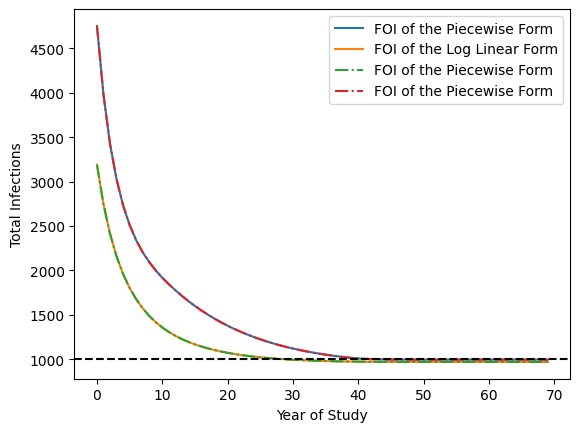

In [11]:
plt.plot(get_infections_by_year(age_piecewise_gt, num_years=70), label="FOI of the Piecewise Form")
plt.plot(get_infections_by_year(age_log_lin_gt, num_years=70), label="FOI of the Log Linear Form")
plt.plot(get_infections_by_year(age_log_lin_gt_2_point_0, num_years=70), label="FOI of the Piecewise Form", linestyle='-.')
plt.plot(get_infections_by_year(age_piecewise_gt_2_point_0, num_years=70), label="FOI of the Piecewise Form", linestyle='-.')
plt.axhline(1000, color="black", linestyle="--")
plt.ylabel("Total Infections")
plt.xlabel("Year of Study")
plt.legend()
plt.show()

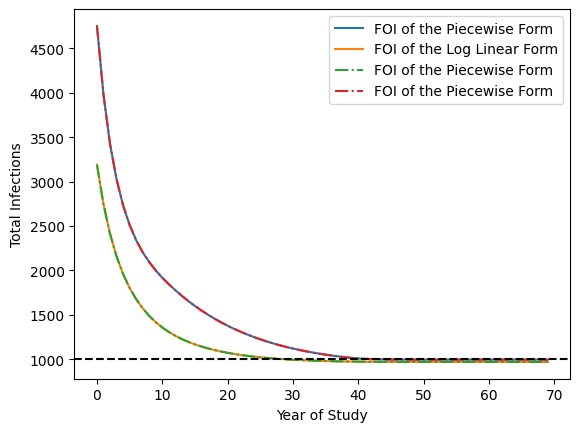

In [12]:
plt.plot(get_infections_by_year(age_piecewise_gt, num_years=70), label="FOI of the Piecewise Form")
plt.plot(get_infections_by_year(age_log_lin_gt, num_years=70), label="FOI of the Log Linear Form")
plt.plot(get_infections_by_year(age_log_lin_gt_2_point_0, num_years=70), label="FOI of the Piecewise Form", linestyle='-.')
plt.plot(get_infections_by_year(age_piecewise_gt_2_point_0, num_years=70), label="FOI of the Piecewise Form", linestyle='-.')
plt.axhline(1000, color="black", linestyle="--")
plt.ylabel("Total Infections")
plt.xlabel("Year of Study")
plt.legend()
plt.show()

In [13]:
direct_init_susc = np.insert(np.ones(MAX_AGE - 1)*np.log(900), 0, np.log(POPULATION_PER_AGE))
params = np.array([np.log(0.3), np.log(0.05), logit(10/MAX_AGE), np.log(10)])
total_params = np.concat([params, direct_init_susc])

In [14]:
# age_piecewise_gt_subset = get_subset_of_simulation_years(
#     si_out=age_piecewise_gt,
#     unobserved_years=10,
#     observed_years=60,
# )
# age_piecewise_gt_subset.shape

In [15]:
# results_nm_lambda_by_age_partial = minimize(
#     objective_function,
#     # x0=np.array([np.log(0.1), np.log(0.1), logit(5/MAX_AGE), np.log(5)]),
#     x0=total_params,
#     args=(ForceOfInfectionMethod.AGE_PIECEWISE, age_piecewise_gt, True, 60, InitialSusceptibleMethod.DIRECT, ),
#     method="Nelder-Mead",
#     options={"maxiter": 1000},
# )
results_nm_lambda_by_age_partial = minimize(
    objective_function,
    # x0=np.array([np.log(0.1), np.log(0.1), logit(5/MAX_AGE), np.log(5)]),
    x0=total_params,
    args=(ForceOfInfectionMethod.AGE_PIECEWISE, age_piecewise_gt, True, 60, InitialSusceptibleMethod.DIRECT, ),
    method="L-BFGS-B",
    options={"maxiter": 100},
)
# results_nm_lambda_by_age_partial = minimize(
#     objective_function,
#     x0=[0.1, 0.1],
#     args=(LambdaVariationMethod.AGE, si_out_foi_by_age_gt, True, True, False),
    
#     bounds=[(0.01, 0.5), (0.01, 0.5)],
#     options={"maxiter": 100},
# )

In [16]:
np.exp(results_nm_lambda_by_age_partial.x[:4])

array([ 0.21 ,  0.079,  0.25 , 10.   ])

In [17]:
(expit(results_nm_lambda_by_age_partial.x[:4][2])*MAX_AGE).astype(int)

np.int64(10)

In [22]:
predicted_res = catalytic_model(
    model_params=results_nm_lambda_by_age_partial.x,
    force_of_infection_method=ForceOfInfectionMethod.AGE_PIECEWISE,
    initial_susceptible_method=InitialSusceptibleMethod.DIRECT,
    num_years=60,
    include_births=True,
    deterministic=True,
)

In [23]:
predicted_res.shape, age_piecewise_gt.shape

((3, 71, 51), (3, 71, 51))

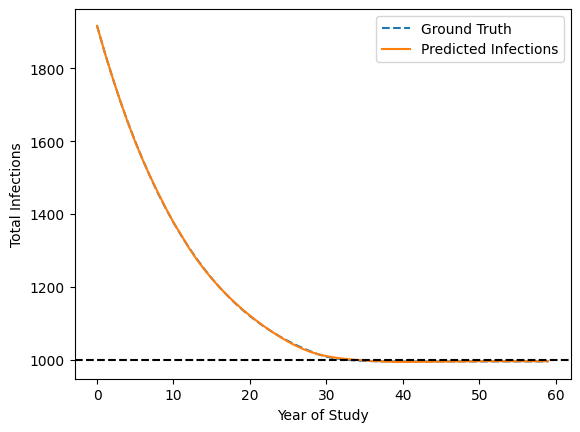

In [25]:
plt.plot(get_infections_by_year(age_piecewise_gt, num_years=70)[10:], label="Ground Truth", linestyle='--')
plt.plot(get_infections_by_year(predicted_res, num_years=70)[10:], label="Predicted Infections")
# plt.plot(get_infections_by_year(age_log_lin_gt, num_years=70), label="FOI of the Log Linear Form")
# plt.plot(get_infections_by_year(age_piecewise_gt_2_point_0, num_years=70), label="FOI of the Piecewise Form", linestyle='-.', c='r')
plt.axhline(1000, color="black", linestyle="--")
plt.ylabel("Total Infections")
plt.xlabel("Year of Study")
plt.legend()
plt.show()

In [21]:
# TODO: Actuallly run the simulations!